### Prunning:

Pruning in the context of neural networks is a technique aimed at reducing the complexity of a model by trimming unnecessary parameters. This process can lead to a more efficient model in terms of computational resources, often without significantly sacrificing accuracy. Pruning is particularly beneficial for deploying models on devices with limited resources, such as mobile phones or embedded systems.

- The core idea behind pruning is the identification and elimination of less important connections (weights) in a neural network.

- These are weights that have little to no impact on the output of the network. 

- Removing these weights reduces the number of operations required to make predictions, thereby speeding up the inference process and reducing the memory footprint of the model.

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define the Neural Network Class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(28*28, 256)  # 28*28 is the size of MNIST images
        # Second fully connected layer
        # self.fc2 = nn.Linear(512, 256)
        # Third fully connected layer that outputs 10 classes
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Flatten the image from [28x28] to [784]
        x = x.view(-1, 28*28)
        # Apply ReLU activation function after each fully connected layer, except the last one
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        # Apply softmax on the output of the last layer to get the probability distribution over 10 classes
        return F.log_softmax(x, dim=1)

# Create an instance of the Net
model = Net()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [43]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizing the images
])

# Loading MNIST dataset from torchvision.dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)


In [7]:
import csv
import matplotlib.pyplot as plt
# Initialize CSV file for logging
csv_file = "training_logs.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Training Loss', 'Training Accuracy', 'Test Loss', 'Test Accuracy'])

In [7]:
import torch.optim as optim
from tqdm import tqdm
# Training Function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    print('Train Epoch: {} \tLoss: {:.6f}, Accuracy: {:.2f}%'.format(epoch, train_loss, 100. * correct / len(train_loader.dataset)))
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

# Evaluation Function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss, 100. * correct / len(test_loader.dataset)))
    test_accuracy= 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [44]:
# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
# model.count_params()
sum(p.numel() for p in model.parameters())


203530

In [45]:

# Training and Testing the model
for epoch in tqdm(range(1, 11)):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    # Write to CSV
    # with open(csv_file, mode='a', newline='') as file:
    #     writer = csv.writer(file)
    #     writer.writerow([epoch, train_loss, train_accuracy, test_loss, test_accuracy])


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 0.036489, Accuracy: 10.82%


 10%|█         | 1/10 [00:13<02:02, 13.62s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 2 	Loss: 0.036489, Accuracy: 10.82%


 20%|██        | 2/10 [00:27<01:48, 13.61s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 3 	Loss: 0.036489, Accuracy: 10.82%


 30%|███       | 3/10 [00:40<01:34, 13.52s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 4 	Loss: 0.036489, Accuracy: 10.82%


 40%|████      | 4/10 [00:54<01:21, 13.51s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 5 	Loss: 0.036489, Accuracy: 10.82%


 50%|█████     | 5/10 [01:07<01:07, 13.46s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 6 	Loss: 0.036488, Accuracy: 10.82%


 60%|██████    | 6/10 [01:20<00:53, 13.42s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 7 	Loss: 0.036488, Accuracy: 10.82%


 70%|███████   | 7/10 [01:34<00:40, 13.37s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 8 	Loss: 0.036488, Accuracy: 10.82%


 80%|████████  | 8/10 [01:47<00:26, 13.39s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 9 	Loss: 0.036489, Accuracy: 10.82%


 90%|█████████ | 9/10 [02:01<00:13, 13.42s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%

Train Epoch: 10 	Loss: 0.036490, Accuracy: 10.82%


100%|██████████| 10/10 [02:14<00:00, 13.45s/it]

Test set: Average loss: 2.3304, Accuracy: 10.86%



In [10]:

# Training and Testing the model
for epoch in tqdm(range(1, 11)):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    # Write to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, train_loss, train_accuracy, test_loss, test_accuracy])


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 0.003137, Accuracy: 93.90%


 10%|█         | 1/10 [00:21<03:15, 21.76s/it]

Test set: Average loss: 0.0994, Accuracy: 96.99%

Train Epoch: 2 	Loss: 0.001339, Accuracy: 97.30%


 20%|██        | 2/10 [00:49<03:20, 25.12s/it]

Test set: Average loss: 0.0825, Accuracy: 97.44%

Train Epoch: 3 	Loss: 0.000938, Accuracy: 98.06%


 30%|███       | 3/10 [01:21<03:18, 28.37s/it]

Test set: Average loss: 0.0835, Accuracy: 97.42%

Train Epoch: 4 	Loss: 0.000704, Accuracy: 98.53%


 40%|████      | 4/10 [01:45<02:39, 26.60s/it]

Test set: Average loss: 0.0795, Accuracy: 97.78%

Train Epoch: 5 	Loss: 0.000594, Accuracy: 98.76%


 50%|█████     | 5/10 [02:07<02:04, 24.92s/it]

Test set: Average loss: 0.0785, Accuracy: 98.01%

Train Epoch: 6 	Loss: 0.000518, Accuracy: 98.97%


 60%|██████    | 6/10 [02:33<01:41, 25.26s/it]

Test set: Average loss: 0.0958, Accuracy: 97.73%

Train Epoch: 7 	Loss: 0.000454, Accuracy: 99.02%


 70%|███████   | 7/10 [03:04<01:21, 27.29s/it]

Test set: Average loss: 0.0785, Accuracy: 98.08%

Train Epoch: 8 	Loss: 0.000342, Accuracy: 99.31%


 80%|████████  | 8/10 [03:31<00:54, 27.17s/it]

Test set: Average loss: 0.1095, Accuracy: 97.58%

Train Epoch: 9 	Loss: 0.000339, Accuracy: 99.29%


 90%|█████████ | 9/10 [03:56<00:26, 26.56s/it]

Test set: Average loss: 0.0961, Accuracy: 97.63%

Train Epoch: 10 	Loss: 0.000323, Accuracy: 99.35%


100%|██████████| 10/10 [04:21<00:00, 26.17s/it]

Test set: Average loss: 0.0969, Accuracy: 97.83%



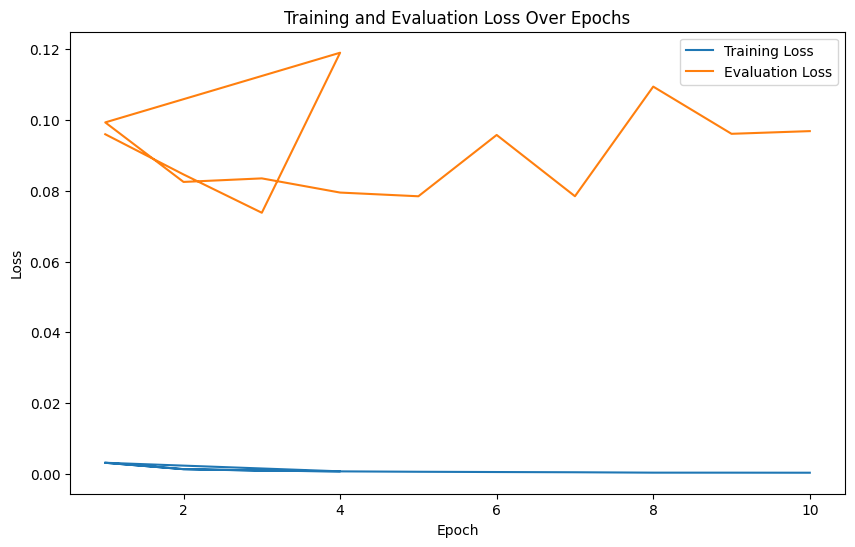

In [11]:
import pandas as pd

# Load the logs into a DataFrame
logs = pd.read_csv(csv_file)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(logs['Epoch'], logs['Training Loss'], label='Training Loss')
plt.plot(logs['Epoch'], logs['Test Loss'], label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.legend()
plt.show()


In [13]:
logs.head(10)

,Epoch,Training Loss,Training Accuracy,Test Loss,Test Accuracy
0,1,0.003144,93.811667,0.096007,97.10
1,2,0.001322,97.306667,0.084641,97.42
2,3,0.000914,98.121667,0.073816,97.71
3,4,0.000713,98.618333,0.119056,96.56
4,1,0.003137,93.896667,0.099358,96.99
5,2,0.001339,97.295000,0.082529,97.44
6,3,0.000938,98.058333,0.083532,97.42
7,4,0.000704,98.525000,0.079524,97.78
8,5,0.000594,98.761667,0.078474,98.01
9,6,0.000518,98.965000,0.095808,97.73


## Now we prune the network

In [3]:
from torch.nn.utils import prune

# Function to apply pruning to the network
def apply_pruning(model, amount=0.1):
    """
    Apply pruning to the layers of the model.
    amount: Fraction of connections to prune.
    """
    for name, module in model.named_modules():
        # Prune 10% of connections in all linear layers
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')  # Make the pruning permanent

# def manual_pruning(model, pruning_percentage=0.1):
#     """
#     Manually prune the lowest magnitude weights from the model's linear layers.

#     Args:
#     model (torch.nn.Module): The neural network model to be pruned.
#     pruning_percentage (float): The percentage of weights to prune from each layer.
#     """
#     for name, module in model.named_modules():
#         # Check if the module is a linear layer
#         if isinstance(module, nn.Linear):
#             # Get the absolute value of weights
#             abs_weights = torch.abs(module.weight.data)
#             # Determine the threshold for pruning
#             threshold = torch.quantile(abs_weights, pruning_percentage)
#             # Create a mask where weights lower than the threshold are set to zero
#             mask = abs_weights.ge(threshold).float()
#             # Apply the mask to the weights (set pruned weights to zero)
#             module.weight.data.mul_(mask)



In [10]:
import csv
from tqdm import tqdm
# Initialize CSV file for logging the pruned network
csv_file_pruned = "training_logs_pruned.csv"
with open(csv_file_pruned, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Pruning Iteration', 'Epoch', 'Training Loss', 'Training Accuracy', 'Test Loss', 'Test Accuracy'])

# Number of pruning iterations
num_pruning_iterations = 5

# Pruning and retraining
for prune_iter in tqdm(range(num_pruning_iterations)):
    print(f"Pruning Iteration: {prune_iter + 1}")

    # Apply pruning
    apply_pruning(model, amount=0.1)  # Prune 10% of connections

    # Reinitialize optimizer (optional, to reset any momentum etc.)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Retrain the model for 10 epochs after each pruning iteration
    for epoch in range(1, 11):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)
        
        # Write to CSV
        with open(csv_file_pruned, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([prune_iter + 1, epoch, train_loss, train_accuracy, test_loss, test_accuracy])


  0%|          | 0/5 [00:00<?, ?it/s]

Pruning Iteration: 1
Train Epoch: 1 	Loss: 0.003226, Accuracy: 93.68%
Test set: Average loss: 0.0945, Accuracy: 96.90%

Train Epoch: 2 	Loss: 0.001336, Accuracy: 97.34%
Test set: Average loss: 0.0755, Accuracy: 97.57%

Train Epoch: 3 	Loss: 0.000934, Accuracy: 98.08%
Test set: Average loss: 0.0941, Accuracy: 97.15%

Train Epoch: 4 	Loss: 0.000763, Accuracy: 98.40%
Test set: Average loss: 0.0797, Accuracy: 97.83%

Train Epoch: 5 	Loss: 0.000553, Accuracy: 98.84%
Test set: Average loss: 0.0787, Accuracy: 97.96%

Train Epoch: 6 	Loss: 0.000497, Accuracy: 98.94%
Test set: Average loss: 0.0904, Accuracy: 97.82%

Train Epoch: 7 	Loss: 0.000462, Accuracy: 99.09%
Test set: Average loss: 0.0790, Accuracy: 97.86%

Train Epoch: 8 	Loss: 0.000385, Accuracy: 99.17%
Test set: Average loss: 0.0886, Accuracy: 97.87%

Train Epoch: 9 	Loss: 0.000326, Accuracy: 99.33%
Test set: Average loss: 0.1125, Accuracy: 97.44%

Train Epoch: 10 	Loss: 0.000345, Accuracy: 99.31%


 20%|██        | 1/5 [11:04<44:19, 664.93s/it]

Test set: Average loss: 0.0957, Accuracy: 97.86%

Pruning Iteration: 2
Train Epoch: 1 	Loss: 0.000360, Accuracy: 99.34%
Test set: Average loss: 0.0937, Accuracy: 98.04%

Train Epoch: 2 	Loss: 0.000291, Accuracy: 99.44%
Test set: Average loss: 0.1137, Accuracy: 97.91%

Train Epoch: 3 	Loss: 0.000259, Accuracy: 99.50%
Test set: Average loss: 0.0926, Accuracy: 98.29%

Train Epoch: 4 	Loss: 0.000257, Accuracy: 99.53%
Test set: Average loss: 0.1057, Accuracy: 97.99%

Train Epoch: 5 	Loss: 0.000290, Accuracy: 99.44%
Test set: Average loss: 0.1261, Accuracy: 97.93%

Train Epoch: 6 	Loss: 0.000254, Accuracy: 99.54%
Test set: Average loss: 0.1162, Accuracy: 97.62%

Train Epoch: 7 	Loss: 0.000166, Accuracy: 99.67%
Test set: Average loss: 0.1176, Accuracy: 98.16%

Train Epoch: 8 	Loss: 0.000195, Accuracy: 99.58%
Test set: Average loss: 0.1184, Accuracy: 97.88%

Train Epoch: 9 	Loss: 0.000268, Accuracy: 99.52%
Test set: Average loss: 0.1264, Accuracy: 97.91%

Train Epoch: 10 	Loss: 0.000164, Accur

 40%|████      | 2/5 [21:05<31:21, 627.27s/it]

Test set: Average loss: 0.1116, Accuracy: 98.35%

Pruning Iteration: 3
Train Epoch: 1 	Loss: 0.000291, Accuracy: 99.55%
Test set: Average loss: 0.1305, Accuracy: 97.93%

Train Epoch: 2 	Loss: 0.000188, Accuracy: 99.71%
Test set: Average loss: 0.1604, Accuracy: 97.77%

Train Epoch: 3 	Loss: 0.000177, Accuracy: 99.67%
Test set: Average loss: 0.1289, Accuracy: 97.86%

Train Epoch: 4 	Loss: 0.000162, Accuracy: 99.69%
Test set: Average loss: 0.1392, Accuracy: 98.15%

Train Epoch: 5 	Loss: 0.000188, Accuracy: 99.65%
Test set: Average loss: 0.1210, Accuracy: 98.23%

Train Epoch: 6 	Loss: 0.000185, Accuracy: 99.71%
Test set: Average loss: 0.1386, Accuracy: 98.22%

Train Epoch: 7 	Loss: 0.000202, Accuracy: 99.68%
Test set: Average loss: 0.1560, Accuracy: 97.93%

Train Epoch: 8 	Loss: 0.000191, Accuracy: 99.65%
Test set: Average loss: 0.1501, Accuracy: 98.06%

Train Epoch: 9 	Loss: 0.000187, Accuracy: 99.69%
Test set: Average loss: 0.1716, Accuracy: 97.72%

Train Epoch: 10 	Loss: 0.000152, Accur

 60%|██████    | 3/5 [31:26<20:48, 624.33s/it]

Test set: Average loss: 0.1556, Accuracy: 98.08%

Pruning Iteration: 4
Train Epoch: 1 	Loss: 0.000305, Accuracy: 99.60%
Test set: Average loss: 0.1903, Accuracy: 98.11%

Train Epoch: 2 	Loss: 0.000169, Accuracy: 99.77%
Test set: Average loss: 0.2128, Accuracy: 98.06%

Train Epoch: 3 	Loss: 0.000182, Accuracy: 99.74%
Test set: Average loss: 0.2044, Accuracy: 97.85%

Train Epoch: 4 	Loss: 0.000166, Accuracy: 99.74%
Test set: Average loss: 0.1766, Accuracy: 98.17%

Train Epoch: 5 	Loss: 0.000181, Accuracy: 99.73%
Test set: Average loss: 0.1883, Accuracy: 98.18%

Train Epoch: 6 	Loss: 0.000123, Accuracy: 99.81%
Test set: Average loss: 0.2045, Accuracy: 97.98%

Train Epoch: 7 	Loss: 0.000168, Accuracy: 99.76%
Test set: Average loss: 0.2171, Accuracy: 98.03%

Train Epoch: 8 	Loss: 0.000203, Accuracy: 99.69%
Test set: Average loss: 0.2028, Accuracy: 98.14%

Train Epoch: 9 	Loss: 0.000182, Accuracy: 99.73%
Test set: Average loss: 0.2036, Accuracy: 98.11%

Train Epoch: 10 	Loss: 0.000163, Accur

 80%|████████  | 4/5 [42:25<10:37, 637.88s/it]

Test set: Average loss: 0.2069, Accuracy: 98.11%

Pruning Iteration: 5
Train Epoch: 1 	Loss: 0.000235, Accuracy: 99.74%
Test set: Average loss: 0.2706, Accuracy: 98.09%

Train Epoch: 2 	Loss: 0.000208, Accuracy: 99.76%
Test set: Average loss: 0.2294, Accuracy: 98.22%

Train Epoch: 3 	Loss: 0.000217, Accuracy: 99.77%
Test set: Average loss: 0.2665, Accuracy: 97.86%

Train Epoch: 4 	Loss: 0.000167, Accuracy: 99.77%
Test set: Average loss: 0.2674, Accuracy: 98.05%

Train Epoch: 5 	Loss: 0.000118, Accuracy: 99.83%
Test set: Average loss: 0.2295, Accuracy: 98.15%

Train Epoch: 6 	Loss: 0.000183, Accuracy: 99.78%
Test set: Average loss: 0.2152, Accuracy: 98.15%

Train Epoch: 7 	Loss: 0.000185, Accuracy: 99.75%
Test set: Average loss: 0.2485, Accuracy: 98.18%

Train Epoch: 8 	Loss: 0.000156, Accuracy: 99.84%
Test set: Average loss: 0.2291, Accuracy: 98.22%

Train Epoch: 9 	Loss: 0.000208, Accuracy: 99.78%
Test set: Average loss: 0.2537, Accuracy: 97.86%

Train Epoch: 10 	Loss: 0.000187, Accur

100%|██████████| 5/5 [53:00<00:00, 636.18s/it]

Test set: Average loss: 0.2725, Accuracy: 97.82%



In [36]:
# logs.tail(20)
# logs.loc[logs['Test Accuracy'].idxmax()]


Pruning Iteration     2.000000
Epoch                10.000000
Training Loss         0.000164
Training Accuracy    99.686667
Test Loss             0.111607
Test Accuracy        98.350000
Name: 19, dtype: float64

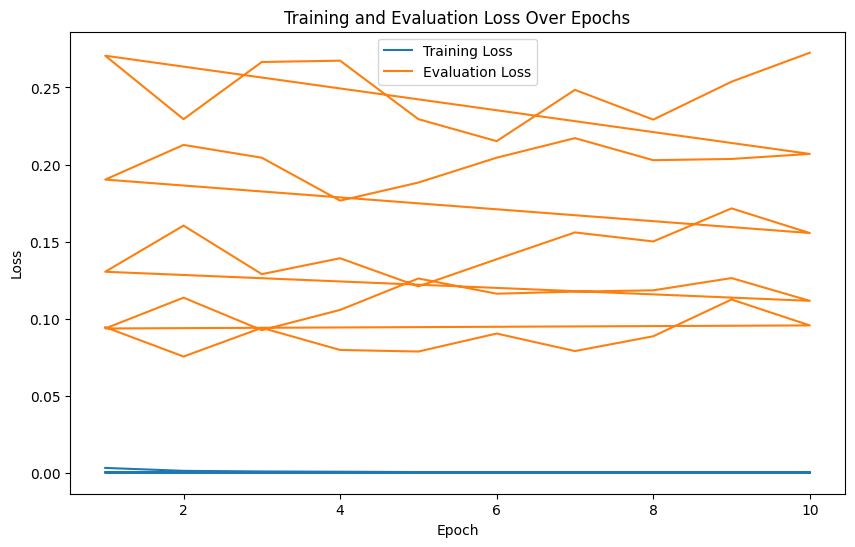

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the logs into a DataFrame
logs = pd.read_csv("training_logs_pruned.csv")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(logs['Epoch'], logs['Training Loss'], label='Training Loss')
plt.plot(logs['Epoch'], logs['Test Loss'], label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.legend()
plt.show()